In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [18]:
# Load dataset
df = pd.read_csv(r"D:\internship\StudentPerformanceFactors.csv")
print("Shape:", df.shape)
print(df.head())


Shape: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  

In [19]:
# Handle missing values
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [20]:
print("Missing after fill:\n", df.isna().sum())


Missing after fill:
 Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


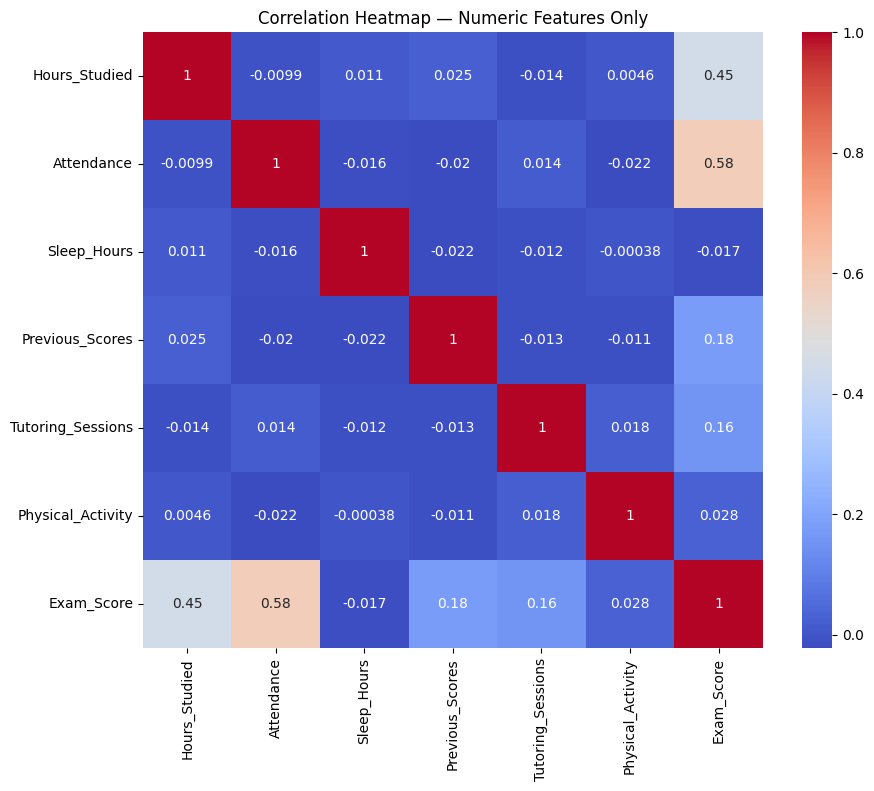

In [21]:
# Correlation heatmap (numeric only)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap — Numeric Features Only")
plt.show()


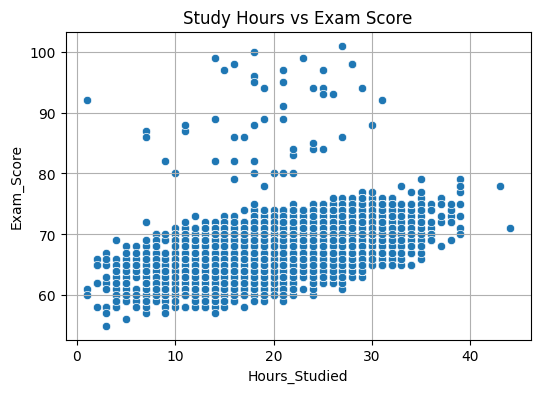

In [22]:
# Scatter: Hours_Studied vs Exam_Score
plt.figure(figsize=(6,4))
sns.scatterplot(x="Hours_Studied", y="Exam_Score", data=df)
plt.title("Study Hours vs Exam Score")
plt.grid(True)
plt.show()


In [23]:
# Prepare features & target
target = "Exam_Score"
features = [col for col in df.columns if col != target]

# One-hot encode categorical variables
X = pd.get_dummies(df[features], drop_first=True)
y = df[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Metrics function
def get_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

metrics_lr_train = get_metrics(y_train, y_pred_train)
metrics_lr_test = get_metrics(y_test, y_pred_test)


In [25]:
# Polynomial Regression
degree = 2
poly_model = make_pipeline(
    PolynomialFeatures(degree, include_bias=False),
    LinearRegression()
)
poly_model.fit(X_train_scaled, y_train)
y_pred_poly_test = poly_model.predict(X_test_scaled)
metrics_poly_test = get_metrics(y_test, y_pred_poly_test)


In [26]:
# Metrics comparison table
metrics_df = pd.DataFrame({
    "Linear Regression (Train)": metrics_lr_train,
    "Linear Regression (Test)": metrics_lr_test,
    f"Polynomial Regression deg={degree} (Test)": metrics_poly_test
}).T

print("\nModel Performance Comparison:")
print(metrics_df)



Model Performance Comparison:
                                         MAE       MSE      RMSE        R²
Linear Regression (Train)           0.498451  4.347985  2.085182  0.717314
Linear Regression (Test)            0.452392  3.256020  1.804445  0.769650
Polynomial Regression deg=2 (Test)  0.642430  3.579020  1.891830  0.746799


C:\Users\muham\AppData\Local\Temp\ipykernel_13256\2839908648.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_feats, palette='viridis')


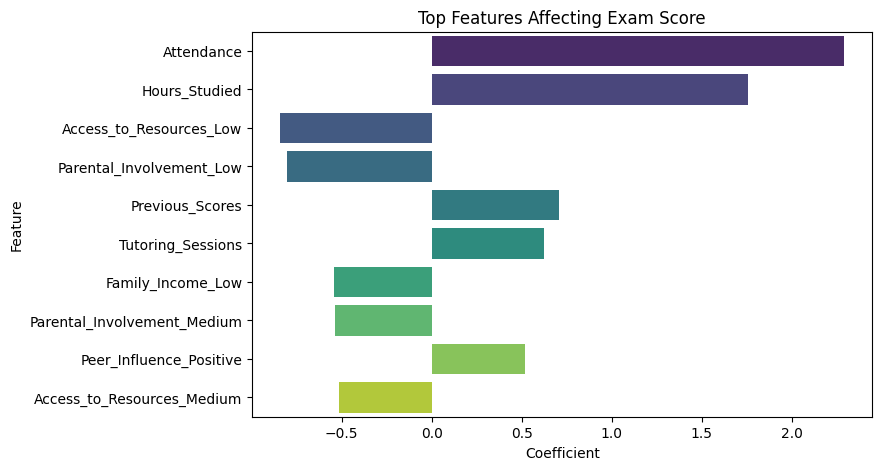

In [27]:
# Feature importance (from Linear Regression)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Bar plot for top features
top_feats = feature_importance.head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=top_feats, palette='viridis')
plt.title('Top Features Affecting Exam Score')
plt.show()


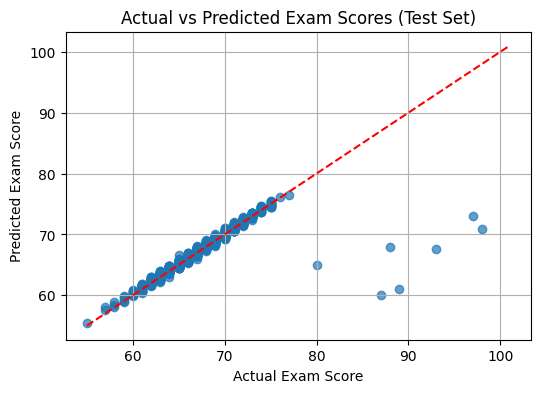

In [28]:
# Actual vs Predicted plot (Test)
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores (Test Set)")
plt.grid(True)
plt.show()
